## AutoMM for Image + Text + Tabular
AutoMM is a deep learning “model zoo” of model zoos. It can automatically build deep learning models that are suitable for multimodal datasets. You will only need to convert the data into the multimodal dataframe format and AutoMM can predict the values of one column conditioned on the features from the other columns including images, text, and tabular data.

In [4]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements

In [4]:
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

In [2]:
!pip install torch==2.0.0+cu117 torchaudio==2.0.0 torchvision==0.15.0+cu117 --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.4.1+cu121
    Uninstalling torch-2.4.1+cu121:
      Successfully uninstalled torch-2.4.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.19.1+cu121
    Uninstalling torchvision-0.19.1+cu121:
      Successfully uninstalled torchvision-0.19.1+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.4.1+cu121
    Uninstalling torchaudio-2.4.1+cu121:
      Successfully uninstalled

## Dataset
For demonstration, we use a simplified and subsampled version of PetFinder dataset. The task is to predict the animals’ adoption rates based on their adoption profile information. In this simplified version, the adoption speed is grouped into two categories: 0 (slow) and 1 (fast).

In [4]:
download_dir = './ag_automm_tutorial'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/petfinder_for_tutorial.zip'
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

Next, we will load the CSV files

In [5]:
import pandas as pd
dataset_path = download_dir + '/petfinder_for_tutorial'
train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)
label_col = 'AdoptionSpeed'

We need to expand the image paths to load them in training.

In [5]:
image_col = 'Images'
train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(';')[0]) # Use the first image for a quick tutorial
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(';')[0])


def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

train_data[image_col].iloc[0]

'/content/ag_automm_tutorial/petfinder_for_tutorial/images/7d7a39d71-1.jpg'

Each animal’s adoption profile includes pictures, a text description, and various tabular features such as age, breed, name, color, and more. Let’s look at an example row of data and display the text description and a picture.

In [6]:
example_row = train_data.iloc[0]

example_row

,0
Type,2
Name,Yumi Hamasaki
Age,4
Breed1,292
Breed2,265
Gender,2
Color1,1
Color2,5
Color3,7
MaturitySize,2


In [7]:
example_row['Description']

"I rescued Yumi Hamasaki at a food stall far away in Kelantan. At that time i was on my way back to KL, she was suffer from stomach problem and looking very2 sick.. I send her to vet & get the treatment + vaccinated and right now she's very2 healthy.. About yumi : - love to sleep with ppl - she will keep on meowing if she's hugry - very2 active, always seeking for people to accompany her playing - well trained (poo+pee in her own potty) - easy to bathing - I only feed her with these brands : IAMS, Kittenbites, Pro-formance Reason why i need someone to adopt Yumi: I just married and need to move to a new house where no pets are allowed :( As Yumi is very2 special to me, i will only give her to ppl that i think could take care of her just like i did (especially on her foods things).."

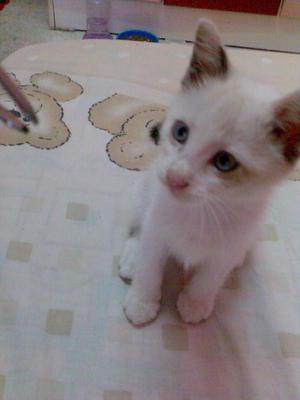

In [8]:
example_image = example_row[image_col]

from IPython.display import Image, display
pil_img = Image(filename=example_image)
display(pil_img)

### Training
Now let’s fit the predictor with the training data.

In [11]:
!apt-get update # Update package lists
!apt-get install -y cuda-toolkit-11-0 # Install CUDA 11.0 Toolkit
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda-11.0/lib64 # Add CUDA library path to system path (replace with the actual path if different)
!pip install --force-reinstall torchaudio -f https://download.pytorch.org/whl/cu110/torch_stable.html #Reinstall torchaudio to ensure it uses the correct CUDA version.

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,027 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,318 kB]
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,361

In [7]:
!pip install --upgrade torch torchvision torchaudio timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.4 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 0.9.16
    Uninstalling timm-0.9.16:
      Successfully uninstalled timm-0.9.16
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires timm<0.10.0,>=0.9.5, but you have timm 1.0.9 which is incompatible.
autogluon-multimodal 1.1.1 requires torch<2.4,>=2.2, but you have torch 2.4.1 which is incompatible.
autogluon-multimodal 1.1.1 requires torchvision<0.19.0,>=0.16.0, but you have torchvision 0.19.1 which is incompatible.


In [2]:
!pip uninstall timm -y
!pip install --upgrade timm


Found existing installation: timm 0.6.12
Uninstalling timm-0.6.12:
  Successfully uninstalled timm-0.6.12
  Using cached timm-1.0.9-py3-none-any.whl.metadata (42 kB)
Using cached timm-1.0.9-py3-none-any.whl (2.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires timm<0.10.0,>=0.9.5, but you have timm 1.0.9 which is incompatible.
autogluon-multimodal 1.1.1 requires torch<2.4,>=2.2, but you have torch 2.0.0+cu117 which is incompatible.
autogluon-multimodal 1.1.1 requires torchvision<0.19.0,>=0.16.0, but you have torchvision 0.15.0+cu117 which is incompatible.


In [2]:
!pip uninstall torch torchvision torchaudio -y
!pip install torch==2.0.0+cu117 torchvision==0.15.0+cu117 torchaudio==2.0.0+cu117 -f https://download.pytorch.org/whl/torch_stable.html


Found existing installation: torch 2.0.0+cu117
Uninstalling torch-2.0.0+cu117:
  Successfully uninstalled torch-2.0.0+cu117
Found existing installation: torchvision 0.15.0+cu117
Uninstalling torchvision-0.15.0+cu117:
  Successfully uninstalled torchvision-0.15.0+cu117
Found existing installation: torchaudio 2.4.1
Uninstalling torchaudio-2.4.1:
  Successfully uninstalled torchaudio-2.4.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu117/torch-2.0.0%2Bcu117-cp310-cp310-linux_x86_64.whl (1843.9 MB)
  Using cached https://download.pytorch.org/whl/cu117/torchvision-0.15.0%2Bcu117-cp310-cp310-linux_x86_64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu117/torchaudio-2.0.0%2Bcu117-cp310-cp310-linux_x86_64.whl (4.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multi

In [6]:
from autogluon.multimodal import MultiModalPredictor
predictor = MultiModalPredictor(label=label_col)
predictor.fit(
    train_data=train_data,
    time_limit=120, # seconds
)

No path specified. Models will be saved in: "AutogluonModels/ag-20241001_234843"
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Pytorch Version:    2.0.0+cu117
CUDA Version:       CUDA is not available
Memory Avail:       10.58 GB / 12.67 GB (83.5%)
Disk Space Avail:   56.84 GB / 107.72 GB (52.8%)
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume 

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

GPU Count: 0
GPU Count to be Used: 0

/usr/local/lib/python3.10/dist-packages/autogluon/multimodal/utils/environment.py:131: UserWarning: Only CPU is detected in the instance. This may result in slow speed for MultiModalPredictor. Consider using an instance with GPU support.
  warnings.warn(
INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: 
  | Name              | Type                | Params | Mode 
------------------------------------------------------------------
0 | model             | MultimodalFusionMLP | 110 M  | train
1 | validation_metric | BinaryAUROC         | 0      | train
2 | loss_func         | CrossEntropyLoss    | 0      | train
------------------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.798   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Time limit reached. Elapsed time is 0:02:12. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/AutogluonModels/ag-20241001_234843")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




### Evaluation
Then we can evaluate the predictor on the test data.

In [7]:
scores = predictor.evaluate(test_data, metrics=["roc_auc"])
scores

Predicting: |          | 0/? [00:00<?, ?it/s]

{'roc_auc': 0.5680000000000001}

### Prediction
Given a multimodal dataframe without the label column, we can predict the labels.

In [8]:
predictions = predictor.predict(test_data.drop(columns=label_col))
predictions[:5]

Predicting: |          | 0/? [00:00<?, ?it/s]

,AdoptionSpeed
8,0
70,0
82,0
28,0
63,0


For classification tasks, we can get the probabilities of all classes.


In [9]:
probas = predictor.predict_proba(test_data.drop(columns=label_col))
probas[:5]

Predicting: |          | 0/? [00:00<?, ?it/s]

,0,1
8,0.986730,0.013270
70,0.986001,0.013999
82,0.859163,0.140837
28,0.955994,0.044006
63,0.927682,0.072318


### Extract Embeddings
Extracting embeddings can also be useful in many cases, where we want to convert each sample (per row in the dataframe) into an embedding vector.

In [10]:
import uuid

model_path = f"./tmp/{uuid.uuid4().hex}-saved_model"
predictor.save(model_path)
loaded_predictor = MultiModalPredictor.load(model_path)
scores2 = loaded_predictor.evaluate(test_data, metrics=["roc_auc"])
scores2

Load pretrained checkpoint: /content/tmp/01b4cfad0ccc4f8ca7559e1239af039d-saved_model/model.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

{'roc_auc': 0.5680000000000001}